In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
import numpy as np
import cv2
import os
import random
import math
import imageio
import shutil
from PIL import Image 
import random
import pandas as pd
import subprocess
from keras.preprocessing.image import ImageDataGenerator
from numba import jit, cuda
import matplotlib.pyplot as plt

In [2]:
tf.debugging.set_log_device_placement(True)
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [3]:
!nvidia-smi


Sun May  7 15:01:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080       WDDM | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P0               39W / 215W|    843MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[]


In [5]:
tf.test.is_built_with_cuda()

False

Did on colab running on local jupyter server:
1) Use d this command in anaconda: jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' \ --port=9090 --no-browser
2) Then copy and paste on of the URLs like: http://localhost:9090/?token=107b5b6de7b8fe5ada010e2ed066c9f6dafc1e567439263c
3) Click 'connect' button and select 'connect local runtime'
4) paste url

#### (d) Data Exploration and Pre-processing

i)

ii)

In [ ]:
#randomly select ceiling 0.7ni images from each folder as train set
directory = '/Users/Daniel/Sport Images'
filenames = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']
images = []

for file in filenames:
    img_list = os.listdir(os.path.join(directory, file))
    images.append(img_list)
    
rand_train_list = []
rand_valid_list = []
rand_test_list = []
for image in images:
    img_len = len(image)
    rand_train = random.sample(image, math.ceil(0.7*img_len))
    rand_train_list.append(rand_train)
    valid_options = [i for i in image if i not in rand_train]
    rand_valid = random.sample(valid_options, math.ceil(0.15*img_len))
    rand_valid_list.append(rand_valid)
    rand_test = [j for j in image if j not in rand_train and j not in rand_valid]
    rand_test_list.append(rand_test)

iii)

In [ ]:
#resizing all the images in train, valid and test sets
directory = '/Users/Daniel/Sport Images'
filenames = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']
file_idx = 0
desired_dim = (224, 224)
new_dir = '/Users/Daniel/updated_img_train'
if os.path.exists(new_dir):
    shutil.rmtree(new_dir)

for img in rand_train_list:
    initial_path = os.path.join(directory, filenames[rand_train_list.index(img)])
    print('Path:'+str(initial_path))
    print('File Idx: '+str(file_idx))
    cont = 0
    cont_img = 0
    for i in img:
        print(i)
        print('image count: '+str(cont_img))
        cont_img += 1
        img_path = os.path.join(initial_path, i)
        if img_path[-4:] == '.gif':
            image = Image.open(img_path)
            image.seek(0)
            image_conv = image.convert('RGB')
            h, w = image_conv.size
            image_arr = np.asarray(image_conv)
            print('Height: '+str(h)+'\nWidth: '+str(w))
            square_pad = max(abs(h-w)//2, 0)
            if h > w:    
                new_image = cv2.copyMakeBorder(image_arr, 0, 0, square_pad, square_pad, cv2.BORDER_CONSTANT)
            elif h < w:
                new_image = cv2.copyMakeBorder(image_arr, square_pad, square_pad, 0, 0, cv2.BORDER_CONSTANT)
            else:
                new_image = cv2.copyMakeBorder(image_arr, 0, 0, 0, 0, cv2.BORDER_CONSTANT)
            new_image = cv2.resize(new_image, desired_dim)
            new_name = i[:-4] + '_resized.jpg'
            if not os.path.exists(new_dir):
                os.mkdir(new_dir)
            new_path = os.path.join(new_dir, filenames[rand_train_list.index(img)])
            if not os.path.exists(new_path):
                os.mkdir(new_path)
            cv2.imwrite(os.path.join(new_path, new_name), new_image)
        else:
            image = cv2.imread(img_path)
            h, w, ch = image.shape
            print('Height: '+str(h)+'\nWidth: '+str(w)+'\n')
            square_pad = max(abs(h-w)//2, 0)
            if h > w:
                new_image = cv2.copyMakeBorder(image, 0, 0, square_pad, square_pad, cv2.BORDER_CONSTANT)
            elif h < w:
                new_image = cv2.copyMakeBorder(image, square_pad, square_pad, 0, 0, cv2.BORDER_CONSTANT)
            else:
                new_image = cv2.copyMakeBorder(image, 0, 0, 0, 0, cv2.BORDER_CONSTANT)
            new_image = cv2.resize(new_image, desired_dim)
            if not os.path.exists(new_dir):
                os.mkdir(new_dir)
            new_path = os.path.join(new_dir, filenames[rand_train_list.index(img)])
            if not os.path.exists(new_path):
                os.mkdir(new_path)
            cv2.imwrite(os.path.join(new_path, i), new_image)
    for files in os.listdir(new_dir):
        cont += 1
    print('Number of files: '+str(cont))
    if img_path[-4:] == '.gif':
        image.close()
    file_idx += 1


Streaming output truncated to the last 5000 lines.
00000526.jpg
image count: 439
Height: 353
Width: 500

00000647.jpg
image count: 440
Height: 333
Width: 500

00000165.jpg
image count: 441
Height: 357
Width: 500

00000123.jpg
image count: 442
Height: 375
Width: 500

00000591.jpeg
image count: 443
Height: 330
Width: 500

Number of files: 3
Path:/Users/Daniel/Sport Images\tennis
File Idx: 3
00000412.jpg
image count: 0
Height: 208
Width: 370

00000362.jpg
image count: 1
Height: 375
Width: 500

00000492.jpg
image count: 2
Height: 312
Width: 500

00000276.jpg
image count: 3
Height: 337
Width: 500

00000437.jpg
image count: 4
Height: 500
Width: 252

00000232.jpg
image count: 5
Height: 333
Width: 500

00000740.jpg
image count: 6
Height: 270
Width: 480

00000652.jpg
image count: 7
Height: 314
Width: 500

00000163.jpg
image count: 8
Height: 333
Width: 500

00000472.jpg
image count: 9
Height: 273
Width: 500

00000266.jpg
image count: 10
Height: 281
Width: 500

00000535.jpg
image count: 11
Height

In [ ]:
directory = '/Users/Daniel/Sport Images'
filenames = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']
file_idx_2 = 0
new_dir_2 = '/Users/Daniel/updated_img_valid'
desired_dim = (224, 224)
if os.path.exists(new_dir_2):
    shutil.rmtree(new_dir_2)
for img_2 in rand_valid_list:
    initial_path = os.path.join(directory, filenames[file_idx_2])
    for i in img_2:
        print(i)
        img_path = os.path.join(initial_path, i)
        if img_path[-4:] == '.gif':
            image = Image.open(img_path)
            image.seek(0)
            image_conv = image.convert('RGB')
            h, w = image_conv.size
            image_arr = np.asarray(image_conv)
            print('Height: '+str(h)+'\nWidth: '+str(w))
            square_pad = max(abs(h-w)//2, 0)
            if h > w:
                new_image = cv2.copyMakeBorder(image_arr, 0, 0, square_pad, square_pad, cv2.BORDER_CONSTANT)
            elif h < w:
                new_image = cv2.copyMakeBorder(image_arr, square_pad, square_pad, 0, 0, cv2.BORDER_CONSTANT)
            else:
                new_image = cv2.copyMakeBorder(image_arr, 0, 0, 0, 0, cv2.BORDER_CONSTANT)
            new_image = cv2.resize(new_image, desired_dim)
            new_name = i[:-4] + '_resized.jpg'
            if not os.path.exists(new_dir_2):
                os.mkdir(new_dir_2)
            new_path = os.path.join(new_dir_2, filenames[rand_valid_list.index(img_2)])
            if not os.path.exists(new_path):
                os.mkdir(new_path)
            cv2.imwrite(os.path.join(new_path, new_name), new_image)
#             imageio.mimsave(os.path.join(new_dir, new_name), new_image)   
        else:
            image = cv2.imread(img_path)
            h, w, ch = image.shape
            print('Height: '+str(h)+'\nWidth: '+str(w)+'\n')
            square_pad = max(abs(h-w)//2, 0)
            if h > w:
                new_image = cv2.copyMakeBorder(image, 0, 0, square_pad, square_pad, cv2.BORDER_CONSTANT)
            elif h < w:
                new_image = cv2.copyMakeBorder(image, square_pad, square_pad, 0, 0, cv2.BORDER_CONSTANT)
            else:
                new_image = cv2.copyMakeBorder(image, 0, 0, 0, 0, cv2.BORDER_CONSTANT)
            new_image = cv2.resize(new_image, desired_dim)
            if not os.path.exists(new_dir_2):
                os.mkdir(new_dir_2)
            new_path = os.path.join(new_dir_2, filenames[rand_valid_list.index(img_2)])
            if not os.path.exists(new_path):
                os.mkdir(new_path)
            cv2.imwrite(os.path.join(new_path, i), new_image)
    if img_path[-4:] == '.gif':
        image.close()
    file_idx_2 += 1

00000271.jpg
Height: 332
Width: 500

00000219.jpg
Height: 500
Width: 500

00000697.jpg
Height: 500
Width: 341

00000005.jpg
Height: 281
Width: 500

00000745.jpg
Height: 252
Width: 500

00000263.jpg
Height: 262
Width: 500

00000051.jpg
Height: 332
Width: 500

00000150.jpg
Height: 250
Width: 500

00000070.jpg
Height: 281
Width: 500

00000480.jpg
Height: 124
Width: 500

00000085.jpg
Height: 333
Width: 500

00000401.jpg
Height: 333
Width: 500

00000443.jpg
Height: 341
Width: 500

00000032.jpg
Height: 250
Width: 500

00000756.jpg
Height: 281
Width: 500

00000466.jpg
Height: 281
Width: 500

00000135.JPG
Height: 281
Width: 500

00000567.jpg
Height: 333
Width: 500

00000660.jpg
Height: 375
Width: 500

00000506.jpg
Height: 200
Width: 300

00000645.jpg
Height: 346
Width: 500

00000243.jpg
Height: 281
Width: 500

00000368.jpg
Height: 375
Width: 500

00000758.jpg
Height: 281
Width: 500

00000141.jpg
Height: 333
Width: 500

00000058.jpg
Height: 268
Width: 500

00000769.jpeg
Height: 332
Width: 500



In [ ]:
directory = '/Users/Daniel/Sport Images'
filenames = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']
file_idx_3 = 0
new_dir_3 = '/Users/Daniel/updated_img_test'
desired_dim = (224, 224)
if os.path.exists(new_dir_3):
    shutil.rmtree(new_dir_3)
for img_3 in rand_test_list:
    initial_path = os.path.join(directory, filenames[file_idx_3])
    for i in img_3:
        print(i)
        img_path = os.path.join(initial_path, i)
        if img_path[-4:] == '.gif':
            image = Image.open(img_path)
            image.seek(0)
            image_conv = image.convert('RGB')
            h, w = image_conv.size
            image_arr = np.asarray(image_conv)
            print('Height: '+str(h)+'\nWidth: '+str(w))
            square_pad = max(abs(h-w)//2, 0)
            if h > w:
                new_image = cv2.copyMakeBorder(image_arr, 0, 0, square_pad, square_pad, cv2.BORDER_CONSTANT)
            elif h < w:
                new_image = cv2.copyMakeBorder(image_arr, square_pad, square_pad, 0, 0, cv2.BORDER_CONSTANT)
            else:
                new_image = cv2.copyMakeBorder(image_arr, 0, 0, 0, 0, cv2.BORDER_CONSTANT)
            new_image = cv2.resize(new_image, desired_dim)
            new_name = i[:-4] + '_resized.jpg'
            if not os.path.exists(new_dir_3):
                os.mkdir(new_dir_3)
            new_path = os.path.join(new_dir_3, filenames[rand_test_list.index(img_3)])
            if not os.path.exists(new_path):
                os.mkdir(new_path)
            cv2.imwrite(os.path.join(new_path, new_name), new_image)
#             imageio.mimsave(os.path.join(new_dir, new_name), new_image)   
        else:
            image = cv2.imread(img_path)
            h, w, ch = image.shape
            print('Height: '+str(h)+'\nWidth: '+str(w)+'\n')
            square_pad = max(abs(h-w)//2, 0)
            if h > w:
                new_image = cv2.copyMakeBorder(image, 0, 0, square_pad, square_pad, cv2.BORDER_CONSTANT)
            elif h < w:
                new_image = cv2.copyMakeBorder(image, square_pad, square_pad, 0, 0, cv2.BORDER_CONSTANT)
            else:
                new_image = cv2.copyMakeBorder(image, 0, 0, 0, 0, cv2.BORDER_CONSTANT)
            new_image = cv2.resize(new_image, desired_dim)
            if not os.path.exists(new_dir_3):
                os.mkdir(new_dir_3)
            new_path = os.path.join(new_dir_3, filenames[rand_test_list.index(img_3)])
            if not os.path.exists(new_path):
                os.mkdir(new_path)
            cv2.imwrite(os.path.join(new_path, i), new_image)
    if img_path[-4:] == '.gif':
        image.close()
    file_idx_3 += 1

00000002.jpeg
Height: 328
Width: 500

00000009.jpg
Height: 268
Width: 500

00000014.jpg
Height: 333
Width: 500

00000020.jpg
Height: 368
Width: 500

00000024.jpg
Height: 281
Width: 500

00000027.jpg
Height: 200
Width: 500

00000028.jpg
Height: 333
Width: 500

00000031.jpg
Height: 396
Width: 500

00000035.jpg
Height: 250
Width: 250

00000040.jpg
Height: 143
Width: 219

00000045.jpg
Height: 350
Width: 500

00000047.jpg
Height: 375
Width: 500

00000049.jpg
Height: 281
Width: 500

00000052.jpg
Height: 281
Width: 500

00000073.JPG
Height: 281
Width: 500

00000076.jpg
Height: 360
Width: 360

00000088.jpg
Height: 231
Width: 499

00000098.jpg
Height: 315
Width: 400

00000110.jpg
Height: 333
Width: 500

00000117.jpg
Height: 333
Width: 500

00000128.jpg
Height: 368
Width: 499

00000136.jpg
Height: 339
Width: 500

00000170.jpg
Height: 500
Width: 500

00000174.jpg
Height: 332
Width: 500

00000176.JPG
Height: 500
Width: 375

00000183.jpg
Height: 280
Width: 500

00000190.jpg
Height: 333
Width: 500



#### (e) Transfer Learning for Image Classification

#### (i)

#### (ii)

In [ ]:
#224x224
#image augmentation
# count = 0

# for i in rand_train_list:
#     j_replace = []
# #     for j in i:
# #         if j[-4:] == '.gif':
# #             j_idx = i.index(j)
# #             i[j_idx] = j[:-4] + '_resized.jpg'
#     for j in i:
#         print(type(j))
# #         if j.endswith('.gif'):
# #             j.replace('.gif', '_resized.jpg')
# #         else:
#         rand_train_list[count] = [j.replace(".gif", "_resized.jpg") if j.endswith(".gif") else j for j in rand_train_list[count]]
#         print('The length of rand_train_list for index: '+str(count)+' is: '+str(len(rand_train_list[count])))
#     count += 1


train_path = '/Users/Daniel/updated_img_train'
valid_path = '/Users/Daniel/updated_img_valid'
test_path = '/Users/Daniel/updated_img_test'
aug_train_path = '/Users/Daniel/aug_img_train'
if not os.path.exists(aug_train_path):
    os.mkdir(aug_train_path) 
else:
    shutil.rmtree(aug_train_path)
    
new_rand_train_list = []

for names in os.listdir(train_path):
    directories = os.listdir(train_path+'/'+names)
    new_list = []
    for i in directories:
        new_list.append(i)
    new_rand_train_list.append(new_list)
# #got all names of all files
# for category in new_rand_train_list:
#     for j in category:
#         if '_cropped' in j or '_zoomed' in j or '_rotated' in j or '_flipped' in j or '_contrasted' in j:
#             d_path = os.path.join(train_path, filenames[new_rand_train_list.index(category)])
#             f_path = os.path.join(d_path, j)
#             print('Deleting: '+str(f_path))
#             os.remove(f_path)
        
#load the images
# for image_lists in new_rand_train_list:
# #     print(len(image_lists))
#     for image_names in image_lists:
#         old_path = os.path.join(train_path, filenames[new_rand_train_list.index(image_lists)])
#         aug_path = os.path.join(aug_train_path, filenames[new_rand_train_list.index(image_lists)])
#         if not os.path.exists(aug_path):
#             os.mkdir(aug_path) 
#         img_path = os.path.join(old_path, image_names)
#         read_img = cv2.imread(img_path)
#         #cropping image
#         x, y, w, h = 200, 200, 300, 300
#         cropped_img = read_img[y:y+h, x:x+w]
#         split_crop = image_names.split('.')
#         cropped_fname = split_crop[0] + '_cropped.' + split_crop[1]
#         cropped_img = cv2.resize(cropped_img, desired_dim)
#         cv2.imwrite(os.path.join(old_path, cropped_fname), cropped_img)
#         cv2.imwrite(os.path.join(aug_path, cropped_fname), cropped_img)
# # #         #randomly zoom an image
# # #         h, w = read_image.shape[:2]
# # #         zoom_center_h = h // 2
# # #         zoom_center_w = w // 2
# # #         zoom_amt = np.random.uniform(1, 1.5)
# # #         zoomed_img = cv2.resize(read_img, None, fx=zoom_amt, fy=zoom_amt, interpolation=cv2.INTER_LINEAR)
# # #         zoomed_fname = image_names[:-4] + '_zoomed' + image_names[-4:]
# # #         cv2.imwrite(os.path.join(train_path, zoomed_fname), zoomed_img)
# # #         print(zoomed_img)

#         #randomly rotate an image
#         spec_angle = np.random.uniform(-180,180)
#         h, w, _ = read_img.shape
#         rotate = cv2.getRotationMatrix2D((w/2, h/2), spec_angle, 1)
#         rotate_img = cv2.warpAffine(read_img, rotate, (w, h))
#         split_rotate = image_names.split('.')
#         rotated_fname = split_rotate[0] + '_rotated.' + split_rotate[1]
#         cv2.imwrite(os.path.join(old_path, rotated_fname), rotate_img)
#         cv2.imwrite(os.path.join(aug_path, rotated_fname), rotate_img)
#STOPPED HERE

#         print(rotate_img)

#         #randomly flip image
#         rand_num = np.random.randint(-1,1)
#         flip_img = cv2.flip(read_img, rand_num)
#         split_flip = image_names.split('.')
#         flipped_fname = split_flip[0] + '_flipped.' + split_flip[1]
#         cv2.imwrite(os.path.join(old_path, flipped_fname), flip_img)
# #         print(flip_img)
        
#         #adjusting the contrast of image randomly
#         a = np.random.uniform(1, 3)
#         b = np.random.uniform(-100, 100)
#         contrasted_img = cv2.convertScaleAbs(read_img, alpha=a, beta=b)
#         split_contrast = image_names.split('.')
#         contrasted_fname = split_contrast[0] + '_contrasted.' + split_contrast[1]
#         cv2.imwrite(os.path.join(old_path, contrasted_fname), contrasted_img)
#         cv2.imwrite(os.path.join(aug_path, contrasted_fname), contrasted_img)
        
#         #translating the image randomly
#         shift_x = np.random.randint(-30, 30)
#         shift_y = np.random.randint(-30, 30)
#         h, w, _ = read_img.shape
#         translate = np.float32([[1, 0, shift_x], [0, 1, shift_y]]) 
#         translated_img = cv2.warpAffine(read_img, translate, (w, h))

aug_gen = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    # vertical_flip= True,
    brightness_range=[0.7, 1.3]
)
# for image_lists in new_rand_train_list:
# #     print(len(image_lists))
#     for image_names in image_lists:
#         old_path = os.path.join(train_path, filenames[new_rand_train_list.index(image_lists)])
#         img_path = os.path.join(old_path, image_names)
train_aug = aug_gen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)
valid_aug = aug_gen.flow_from_directory(
    directory=valid_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)



Found 2297 images belonging to 5 classes.
Found 495 images belonging to 5 classes.


#### (iii) Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
first_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

resnet = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
effnet = EfficientNetB0(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
vgg = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

# @jit(target_backend='cuda')  
def model_resnet(resnet):
    resnet_mod =  Sequential([
        resnet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5), 
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5), 
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5), 
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5), 
        Dense(5, activation='softmax')
    ])
    return resnet_mod

# @jit(target_backend='cuda')  
def model_effnet(effnet):
    effnet_mod = Sequential([
        effnet,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5), 
        Dense(5, activation='softmax')
    ])
    return effnet_mod

# @jit(target_backend='cuda')  
def model_vgg(vgg):
    vgg_mod = Sequential([
        vgg,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5), 
        Dense(5, activation='softmax')
    ])
    return vgg_mod

resnet_mod = model_resnet(resnet)
effnet_mod = model_effnet(effnet)
vgg_mod = model_vgg(vgg)

resnet_mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
effnet_mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
resnet_hist = resnet_mod.fit(train_aug, epochs=50, validation_data=valid_aug, callbacks=[es])


Epoch 1/50
 5/36 [===>..........................] - ETA: 4:19 - loss: 2.5918 - accuracy: 0.2094

KeyboardInterrupt: ignored

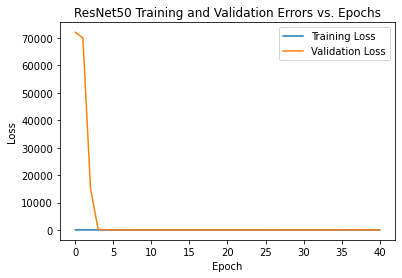

In [ ]:
plt.plot(resnet_hist.history['loss'], label='Training Loss')
plt.plot(resnet_hist.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Errors vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Efficient Net
effnet_hist = effnet_mod.fit(train_aug, epochs=50, validation_data=valid_aug, callbacks=[es])

Epoch 1/50
36/36 [==============================] - 243s 6s/step - loss: 0.7448 - accuracy: 0.7559 - val_loss: 0.3189 - val_accuracy: 0.8785
Epoch 2/50
36/36 [==============================] - 225s 6s/step - loss: 0.2630 - accuracy: 0.9164 - val_loss: 0.3991 - val_accuracy: 0.8846
Epoch 3/50
36/36 [==============================] - 225s 6s/step - loss: 0.1377 - accuracy: 0.9473 - val_loss: 0.2573 - val_accuracy: 0.9271
Epoch 4/50
36/36 [==============================] - 225s 6s/step - loss: 0.1330 - accuracy: 0.9539 - val_loss: 0.3908 - val_accuracy: 0.8947
Epoch 5/50
36/36 [==============================] - 225s 6s/step - loss: 0.0905 - accuracy: 0.9708 - val_loss: 0.3582 - val_accuracy: 0.9008
Epoch 6/50
36/36 [==============================] - 225s 6s/step - loss: 0.0935 - accuracy: 0.9726 - val_loss: 0.3828 - val_accuracy: 0.9251
Epoch 7/50
36/36 [==============================] - 225s 6s/step - loss: 0.0785 - accuracy: 0.9726 - val_loss: 0.2675 - val_accuracy: 0.9312
Epoch 8/50
36

In [ ]:
plt.plot(effnet_hist.history['loss'], label='Training Loss')
plt.plot(effnet_hist.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 Training and Validation Errors vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#VGG16
vgg_hist = vgg_mod.fit(train_aug, epochs=50, validation_data=valid_aug, callbacks=[es])

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
plt.plot(vgg_hist.history['loss'], label='Training Loss')
plt.plot(vgg_hist.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Training and Validation Errors vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### (iv) Train the networks ResNet50, EfficientNetB0, and VGG16 for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [ ]:
#bulding the neural network using Keras
# valid_path = '/Users/Daniel/updated_img_valid'
# num_epochs = 50
# models = [ResNet50, VGG16, EfficientNetB0]
# dimensions = (1000,1000)
# train_list_baseball = []
# train_list_basketball = []
# train_list_fencing = []
# train_list_tennis = []
# train_list_volleyball = []

# valid_list_baseball = []
# valid_list_basketball = []
# valid_list_fencing = []
# valid_list_tennis = []
# valid_list_volleyball = []

# for filename in filenames:
#     make_path = os.path.join(aug_train_path, filename)
#     all_path_files = os.listdir(make_path)
#     for i in all_path_files:
# #         if i.endswith('.webp'):
# #             print(i)
# #             i = Image.open(os.path.join(make_path, i)).convert('RGB')
# #             i.save(os.path.join(make_path, i[:-5]), 'png')
# #             print(i)
# # #             webp = os.path.join(make_path, i)
# # #             print(webp)
# # #             j = i[:-5] + '.jpg'
# # #             jpg = os.path.join(make_path, j)
# # #             os.mkdir(jpg)
# # #             print(jpg)
# # #             subprocess.run(['webp', '-quiet', '-q', '80', '-o', jpg, webp])
# # #             i = jpg
# # #             print(i)
# # #             image = Image.open
# # #             i = i.convert('RGB')
# # #             i = i[:-5] + '.jpg'
# # #             print(i)
#         image = Image.open(os.path.join(make_path, i))
#         if filename == 'baseball':
#             train_list_baseball.append(image)
#         elif filename == 'basketball':
#             train_list_basketball.append(image)
#         elif filename == 'fencing':
#             train_list_fencing.append(image)
#         elif filename == 'tennis':
#             train_list_tennis.append(image)
#         elif filename == 'volleyball':
#             train_list_volleyball.append(image)
#     image.close()

# print(train_list_baseball)





[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D3434160>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D3434190>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D3434220>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D3434280>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D34342B0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D3434310>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D34343D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D3434400>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D3434460>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D34344C0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D3434520>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x1C7D3